In [2]:
from quantum_simulator_EC import system
import matplotlib.pyplot as plt
from reinforce_keras_EC import Agent
from copy import copy, deepcopy
import time
from IPython.display import clear_output
from termcolor import colored

%matplotlib inline
%load_ext autoreload
%autoreload 2


2023-06-25 16:05:46.579442: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
s = system(1200, N=3, P=0.1)

agent = Agent(alpha=0.00005,  gamma=0.95, n_actions=len( s.actions ), lambda_entr=5e-1)
RQ_history = []

#agent.load_policy('saved_model_200gates/my_model')
#agent.policy.summary()

In [4]:
num_epochs = 2
N_gates = 200
PCA_nb = 6
batch_size = 64

agent.state_memory = []
agent.action_memory = []
agent.reward1_memory = []
agent.reward2_memory = []

t2=-1
t1=0

for jj in range(num_epochs):
    
    clear_output(wait=False)
    print("-- number_of_epochs_trained: ", agent.number_of_epochs_trained )
    print('-- sequence generation time =', (t2-t1)/batch_size  )
    print('-- epoch: ',jj, end=': ')
    RQs_at_end = []
    
    t1 = time.time()
        

    counter=0
    for ii in range(batch_size):
        
        counter+=1
        if counter >= 8:
            print('.',end='')
            counter=0
            
        seq_obsvs = []
        seq_acts = []
        seq_rwds1 = []
        seq_rwds2 = []
    
        s.initialise_all()
        
        for kk in range( N_gates ):
        
            state = s.generate_net_input_state(PCA_nb)
            #net_input = s.generate_net_input_FULL(PCA_nb)
            action = agent.choose_action( state )
            
            reward1, reward2 = s.apply_action(action)
            #new_state = s.generate_net_input_state(PCA_nb)
            
            seq_obsvs.append( state )
            seq_acts.append( action )
            seq_rwds1.append( reward1 )
            seq_rwds2.append( reward2 )
            
            s.time_evolve()
            s.last_action = action
            
        
        agent.store_transition(seq_obsvs, seq_acts, seq_rwds1, seq_rwds2)
        RQs_at_end.append( s.RQ() )
        
    t2 = time.time()
    
    RQ_history.append( np.array(RQs_at_end).mean() )
    
    print("|", end='')
    agent.learn()
    print("|")

    

-- number_of_epochs_trained:  1
-- sequence generation time = 1.2103496380150318
-- epoch:  1: .....

KeyboardInterrupt: 

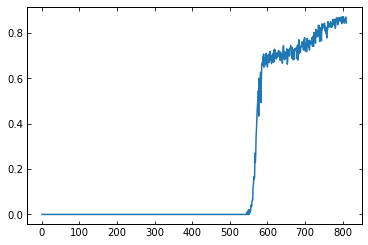

In [4]:
plt.plot(RQ_history)
plt.show()

In [65]:
!mkdir -p saved_model_200gates

In [53]:
agent.policy.save('saved_models/my_model_N=3_200gates_V8_entr5e-1_al0.00005')
agent.policy.summary()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_models/my_model_N=3_200gates_V8_entr5e-1_al0.00005/assets
Model: "policy_gradient_network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  121200    
_________________________________________________________________
dense_1 (Dense)              multiple                  90300     
_________________________________________________________________
dense_2 (Dense)              multiple                  3913      
Total params: 215,413
Trainable params: 215,413
Non-trainable params: 0
_________________________________________________________________


In [52]:
score_history_TEST = []
RQ_history_TEST = []

num_epochs = 1
N_gates = 200
PCA_nb = 6
batch_size = 1

for jj in range(num_epochs):
    
    qb =['','','']
    clear_output(wait=False)
    print("-- number_of_epochs_trained: ", agent.number_of_epochs_trained )
    print('-- sequence generation time =', (t2-t1)/batch_size  )
    print('-- epoch=',jj, end=': ')
    RQs_at_end = []
    
    for ii in range(batch_size):
        
        print('.',end='')
    
        s.initialise_all()
        
        for kk in range( N_gates ):
        
            state = s.generate_net_input_state(PCA_nb)
            #net_input = s.generate_net_input_FULL(PCA_nb)
            action = agent.choose_action( state )
            a_type = s.get_action_type(action)
            
            reward1, reward2 = s.apply_action(action)
            
            s.time_evolve()
            s.last_action = action
            
            a_type = s.get_action_type(action)
            if a_type=='IDLE':
                for j in range(s.N_qubits):
                    qb[j]+='- '
            if a_type=='CNOT':
                qb1 = s.cnot_pairs[s.actions[action]][0]
                qb2 = s.cnot_pairs[s.actions[action]][1]
                qb[qb1]+=colored('C ', 'blue')
                qb[qb2]+=colored('X ', 'blue')
                for j in range(s.N_qubits):
                    if (j != qb1) and (j != qb2):
                        qb[j]+='- '
            if a_type=='BITFLIP':
                qb[ s.actions[action] ]+='F '
                for j in range(s.N_qubits):
                    if (j != s.actions[action]):
                        qb[j]+='- '
            if a_type=='ZMEASUREMENT':
                qb[s.actions[action]]+=colored('M ', 'red')
                for j in range(s.N_qubits):
                    if (j != s.actions[action]):
                        qb[j]+='- '
            
        
        #agent.store_transition(seq_obsvs, seq_acts, seq_rwds1, seq_rwds2)
        RQs_at_end.append( s.RQ() )
        print(" ")
        print("*******************************************************")
        print("Q0: ", qb[0])
        print("Q1: ", qb[1])
        print("Q2: ", qb[2])
        print("*******************************************************")
        print(" ")
        
    RQ_history_TEST.append( np.array(RQs_at_end).mean() )




-- number_of_epochs_trained:  811
-- sequence generation time = -1.2701168060302734
-- epoch= 0: . 
*******************************************************
Q0:  C C F - F - - F F F F F - F F F - - F - F F F F F - F - - F F F - - F F - F - F C C - - F F F F - F - F F F - F F F F F F F - F F - F F F F F F F - - - F F - F - F - - C - - F - - - C F F F F - - F - - F - F F F - F - F F - F F F F - F - C C F - F F F - F - F F F F - F F F - F - F - F F F F F F - F - F F - F F F F F F F F F - F - - F F - F F F F F F F F - F - F F - - F - - - - F F - - F F - - F F 
Q1:  X - - - - - - - - - - - F - - - - - - - - - - - - F - F F - - - F - - - - - F - - - - - - - - - - - F - - - F - - - - - - - - - - - - - - - - - - F F - - - - - - - - F - F F - F - F - - - - - - - - F F - F - - - F - F - - - - - - - F - F - - - F - - - F - - - - - - F - - - F - F - F - - - - - - F - - - - F - - - - - - - - - - - - F - - - - - - - - - - - - - - - - F - - F - F - - - - - - - F - - - 
Q2:  - X - F - F F - - - - - - -

In [72]:
num_epochs = 10
N_gates = 200
batch_size = 1
score_history_idle = []
RQ_history_idle = []

for jj in range(num_epochs):
    
    clear_output(wait=False)
    print('epoch=',jj, end=': ')
    RQs_at_end_idle = []
    scores_idle=[]
        
    for ii in range(batch_size):
        
        print('.',end='')
        score_idle=0
    
    
        s.initialise_rho_mats()
        for kk in range( N_gates ):
        
            reward1, reward2 = s.apply_action(0)
            #t2b = time.time()
            
            score_idle += reward1+reward2 
            
            s.time_evolve()
        
        scores_idle.append( score )
        RQs_at_end_idle.append( s.RQ() )
    
    score_history_idle.append( np.array(scores_idle).mean() )
    RQ_history_idle.append( np.array(RQs_at_end_idle).mean() )
    
    print("|", end='')
    print("|")

epoch= 9: .||


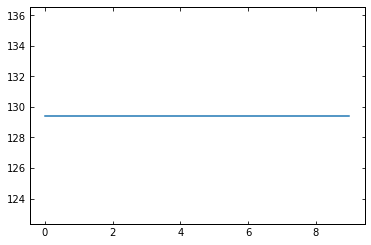

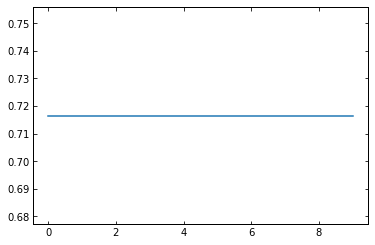

In [47]:
plt.plot(score_history_idle)
plt.show()
plt.plot(RQ_history_idle)
plt.show()

In [13]:
s.actions

[None, 0, 1, 2, 3, 4, 5, 0, 1, 2, 0, 1, 2]